In [1]:
from dolfinx import mesh, fem, io
import ufl
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt

from dolfinx.fem import Constant, FunctionSpace,Function, dirichletbc,locate_dofs_geometrical,form
from ufl import dx, ds, grad, TrialFunction, TestFunction, FacetNormal, lhs, rhs
from dolfinx.fem.petsc import LinearProblem


class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def all_boundary(domain, space):
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    boundary_dofs = fem.locate_dofs_topological(
        space,
        domain.topology.dim - 1,
        boundary_facets,
        )
    return boundary_dofs


dot = Infix(ufl.inner)


def L_errors(uS, def_uEx):
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain, ('CG', uS.function_space.element.space_dimension)
        )
    uEx = Function(V_err)
    uEx.interpolate(def_uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def graph2D(fig, lists):
    """Create graph

    Args:
        fig : 
        lists (list): geometry_x, u_array,axe,title
    """

    def data_construct(geometry, x_array):
        data = np.column_stack((geometry[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        geometry_x, u_array, axe, title = list

        levels = np.linspace(u_array.min(), u_array.max(), 10)
        axe.set_title(title)
        plot = axe.tricontourf(
            *data_construct(geometry_x, u_array), levels=levels
            )
        axe.set_aspect(1)
        fig.colorbar(plot, ax=axe)
    return

In [2]:
N = 10
def_uEx = lambda x: 1 + x[0]**2 + 2 * x[1]**2

def_uD1 = lambda x: 1 + 2 * x[1]**2
def_uD2 = lambda x: 2 + 2 * x[1]**2

def_uNe = lambda x: -4 * x[1]

defc_f = -6

In [3]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = FunctionSpace(domain, ('CG', 1))


def bound1(x):
    return np.isclose(x[0], 0)


uD1 = Function(V)
uD1.interpolate(def_uD1)
bound1_dofs = locate_dofs_geometrical(V, bound1)
bcs1 = dirichletbc(uD1, bound1_dofs)


def bound2(x):
    return np.isclose(x[0], 1)


uD2 = Function(V)
uD2.interpolate(def_uD2)
bound2_dofs = locate_dofs_geometrical(V, bound2)
bcs2 = dirichletbc(uD2, bound2_dofs)

bcs = [bcs1, bcs2]

uNe = Function(V)
uNe.interpolate(def_uNe)

u, v = TrialFunction(V), TestFunction(V)
f = Constant(V, ScalarType(-6))

F = (grad(u)|dot|grad(v)) * dx - (f*v) * dx + (uNe*v) * ds

In [4]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        },
    )
uS = problem.solve()

In [5]:
error = L_errors(uS=uS, def_uEx=def_uEx)
print(f'L1 error = {error[0]:.2e} \nL2 error = {error[1]:.2e}')

L1 error = 5.00e-03 
L2 error = 5.27e-03


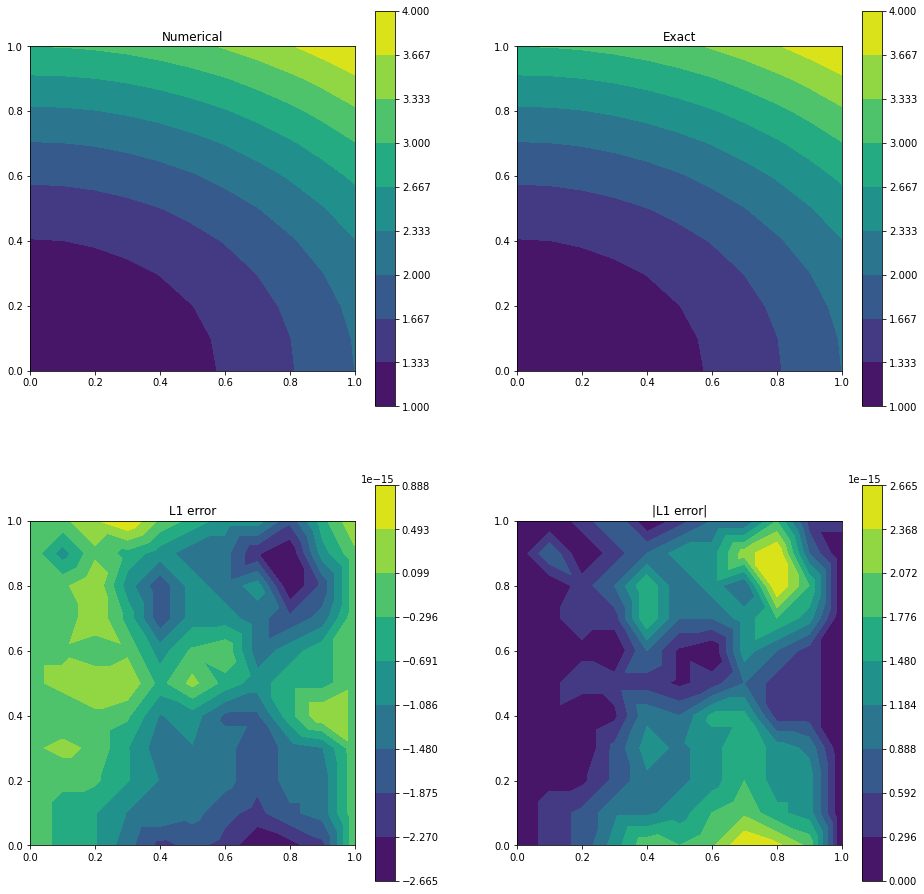

In [6]:
uEx = Function(V)
uEx.interpolate(def_uEx)

fig, ((ax_S, ax_Ex), (ax_dif, ax_dif2)) = plt.subplots(2, 2)
fig.set_size_inches(16, 16)

lis = [
    [domain.geometry.x, uS.x.array, ax_S, 'Numerical'],
    [domain.geometry.x, uEx.x.array, ax_Ex, 'Exact'],
    [domain.geometry.x, uS.x.array - uEx.x.array, ax_dif, 'L1 error'],
    [domain.geometry.x, np.abs(uS.x.array - uEx.x.array), ax_dif2, '|L1 error|'],
    ]

graph2D(fig=fig, lists=lis)